In [1]:
import os
import random 

!pip install pydot
!pip install graphviz
!pip install -q mlflow
!pip install tqdm
!pip install tensorflow_addons
!pip install geopandas
!pip install rasterio
!pip install geopandas fiona
!pip install sklearn

import cv2
import random
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import rasterio
import rasterio.features
import fiona
import geopandas as gpd
import rasterio
import rasterio.features
import math
import mlflow
import mlflow.tensorflow

from keras.utils.vis_utils import plot_model
from tqdm import tqdm
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import Affine, from_origin
from PIL import Image, ImageDraw
from pyproj import Transformer
from shapely.geometry import shape, box
from rasterio.features import geometry_mask, rasterize
from rasterio.transform import Affine, from_origin
from PIL import Image, ImageDraw
from pyproj import Transformer
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


# **Data prepeartion from building.shp and simplified.shp**

In [4]:
class BuildingsDataset(tf.keras.utils.Sequence):
    def __init__(self, shape_path_original, shape_path_generalized, img_size=(128, 128), batch_size=4500):
        self.shape_path_original = shape_path_original
        self.shape_path_generalized = shape_path_generalized

        self.batch_size = batch_size
        self.img_size = img_size
    
        self.gdf_original = gpd.read_file(self.shape_path_original)
        self.gdf_generalized = gpd.read_file(self.shape_path_generalized)
    
    def __len__(self):
        return math.ceil(len(self.gdf_original) / self.batch_size)

    def image_from_geometry(self, geom):
        bounds = geom.bounds # (minx, miny, maxx, maxy)

        # Calculate the current width and height of the building
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]

        # Calculate the desired width and height of the building (e.g., 50% of the original size)
        desired_width = width * 1.5
        desired_height = height * 1.5

        # Calculate the adjustment needed to center the building in the image
        dx = (width - desired_width) / 2
        dy = (height - desired_height) / 2

        # Adjust the bounds of the building's footprint
        new_bounds = (
            bounds[0] + dx,
            bounds[1] + dy,
            bounds[2] - dx,
            bounds[3] - dy
        )

        transform = from_origin(new_bounds[0], new_bounds[3], (new_bounds[2] - new_bounds[0]) / self.img_size[0], (new_bounds[3] - new_bounds[1]) / self.img_size[1])

        # Create a new binary image of size 128x128 pixels
        shapes = [(geom, 255)]
        img_array = rasterize(shapes, out_shape=self.img_size, transform=transform)

        return img_array
    
    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.gdf_original))
        batch_x = self.gdf_original[low:high]['geometry']
        batch_y = self.gdf_generalized[low:high]['geometry']

        return (
            [self.image_from_geometry(geom_orig) for geom_orig in batch_x], 
            [self.image_from_geometry(geom_gen) for geom_gen in batch_y]
        )
    

In [5]:
dataset = BuildingsDataset('data/buildings.shp', 'data/simplified.shp')
data = random.sample(list(dataset), 1)[0]

for i in range(dataset.batch_size):
    
    if (i < 4000):
        outfile1 = 'data4k/training/image/%s.png' % (i + 1)
        outfile2 = 'data4k/training/mask/%s.png' % (i + 1)
        a = data[0][i]
        b = data[1][i]
        img.imsave(outfile1,a,cmap='gray')
        img.imsave(outfile2,b,cmap='gray')
    

    else:
        outfile5 = 'data4k/testing/image/%s.png' % (i- 3999)
        outfile6 = 'data4k/testing/mask/%s.png' % (i - 3999)
        a = data[0][i]
        b = data[1][i]
        img.imsave(outfile5,a,cmap='gray')
        img.imsave(outfile6,b,cmap='gray')
    

# **Reading the Data**

In [6]:
image_path_train = 'data4k/training/image'
mask_path_train = 'data4k/training/mask'
image_path_test = 'data4k/testing/image'

In [7]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)

def getData(X_shape):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)

    for i in tqdm(images):
        if i.endswith('png'):
            im = cv2.imread(os.path.join(image_path_train, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            mask = cv2.imread(os.path.join(mask_path_train, i), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
       
            im_array.append(im)
            mask_array.append(mask)
    
    # return list
    return im_array, mask_array

In [8]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, shape)
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

In [9]:
dim, n_samples = 256, 500 

images, masks = getData(dim)
X_test = get_test(dim, n_samples = n_samples)




100%|██████████| 500/500 [00:00<00:00, 1108.35it/s]


In [10]:
images = np.array(images).reshape(len(images), dim, dim, 1)
masks= np.array(masks).reshape(len(masks), dim, dim, 1)

In [11]:
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

print(images.shape, masks.shape)
print(X_test.shape)

(4000, 256, 256, 1) (4000, 256, 256, 1)
(500, 256, 256, 1)


# **Visualise the Data**

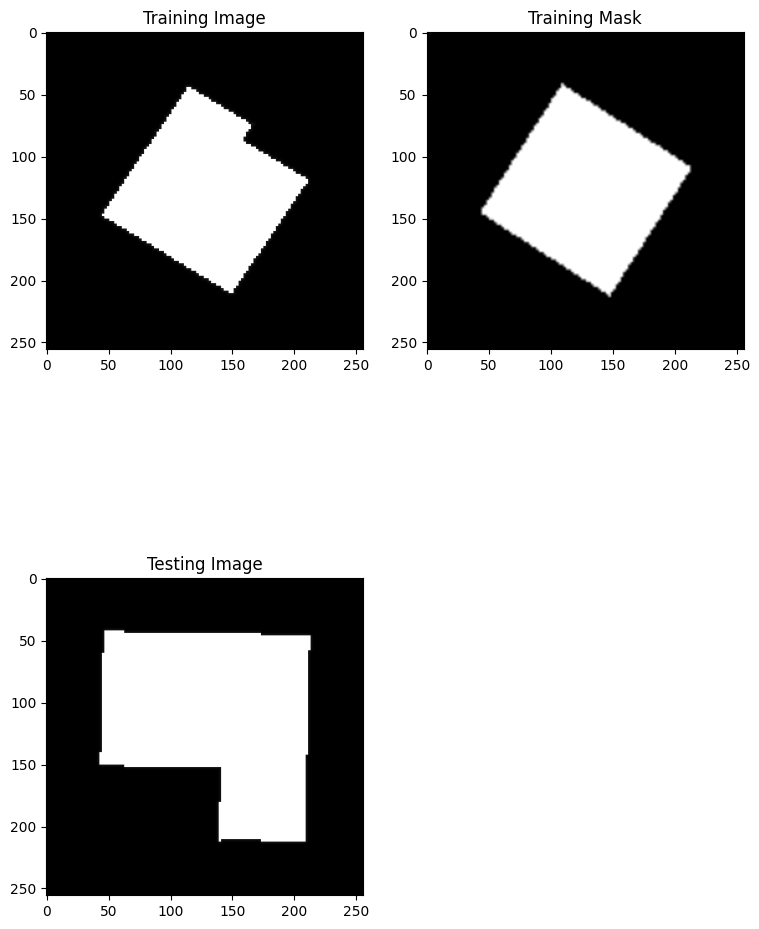

In [12]:
i = 200
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(images[i].reshape(256, 256), cmap='gray')
axs[0, 1].imshow(masks[i].reshape(256, 256), cmap='gray')
axs[1, 0].imshow(X_test[i].reshape(256, 256), cmap='gray')

axs[0, 0].set_title('Training Image')
axs[0, 1].set_title('Training Mask')
axs[1, 0].set_title('Testing Image')


fig.delaxes(axs[1, 1])

In [13]:

from sklearn.model_selection  import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split((images - 127.0) / 127.0, 
                                                  (masks > 127).astype(np.float32), 
                                                  test_size = 0.2, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

# **RES-U-Net**

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [15]:
def bn_act(x, act=True):
    x = tensorflow.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tensorflow.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
    c = tensorflow.keras.layers.Concatenate()([u, xskip])
    return c

In [16]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tensorflow.keras.layers.Input((dim, dim, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model

In [17]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

# **Model Summary**

In [18]:
mlflow.autolog()
model = ResUNet()
adam = tensorflow.keras.optimizers.Adam()
model.compile(optimizer=adam, loss=loss, metrics=metrics)
model.summary()

2023/07/16 16:58:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/07/16 16:58:49 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [19]:

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [20]:
weight_path="{}_res_unet.h5".format('BEST')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

callbacks_list = [checkpoint, reduceLROnPlat]

In [21]:
#initialize random seeds so results are repeatable


random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# **Training The Model**

In [22]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=32, epochs=50,
                callbacks=callbacks_list)

2023/07/16 16:59:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '090876c5ffa64284a6bb33f2ffe3030f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.0772 - dice_coef: 0.9228 - jaccard_coef: 0.8598 - binary_accuracy: 0.9583 - precision: 0.9309 - recall: 0.9212
Epoch 1: val_loss improved from inf to 0.24135, saving model to BEST_res_unet.h5
100/100 [==============================] - 82s 700ms/step - loss: 0.0772 - dice_coef: 0.9228 - jaccard_coef: 0.8598 - binary_accuracy: 0.9583 - precision: 0.9309 - recall: 0.9212 - val_loss: 0.2413 - val_dice_coef: 0.7587 - val_jaccard_coef: 0.6113 - val_binary_accuracy: 0.8430 - val_precision: 0.6495 - val_recall: 0.9509 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.0655 - dice_coef: 0.9345 - jaccard_coef: 0.8771 - binary_accuracy: 0.9630 - precision: 0.9321 - recall: 0.9377
Epoch 2: val_loss did not improve from 0.24135
100/100 [==============================] - 67s 672ms/step - loss: 0.0655 - dice_coef: 0.9345 - jaccard_coef: 0.8771 - binary_accuracy: 0.9630 - precision: 0.9321 - recal

INFO:tensorflow:Assets written to: /tmp/tmp8wqo9g5x/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp8wqo9g5x/model/data/model/assets
2023/07/16 17:55:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8wqo9g5x/model, flavor: tensorflow), fall back to return ['tensorflow==2.9.2']. Set logging level to DEBUG to see the full traceback.
2023/07/16 17:55:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.9/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


# **Plot Training Response**

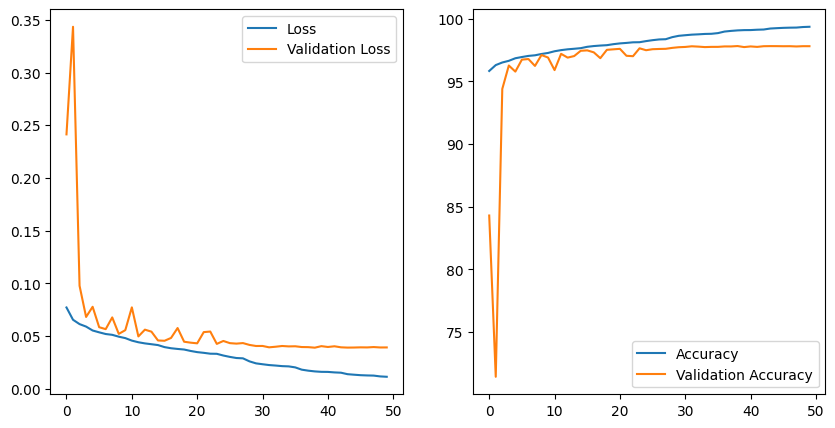

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

# **Prediction on Validation Dataset**

In [24]:
preds_val = model.predict(X_val)

25/25 [==============================] - 4s 171ms/step


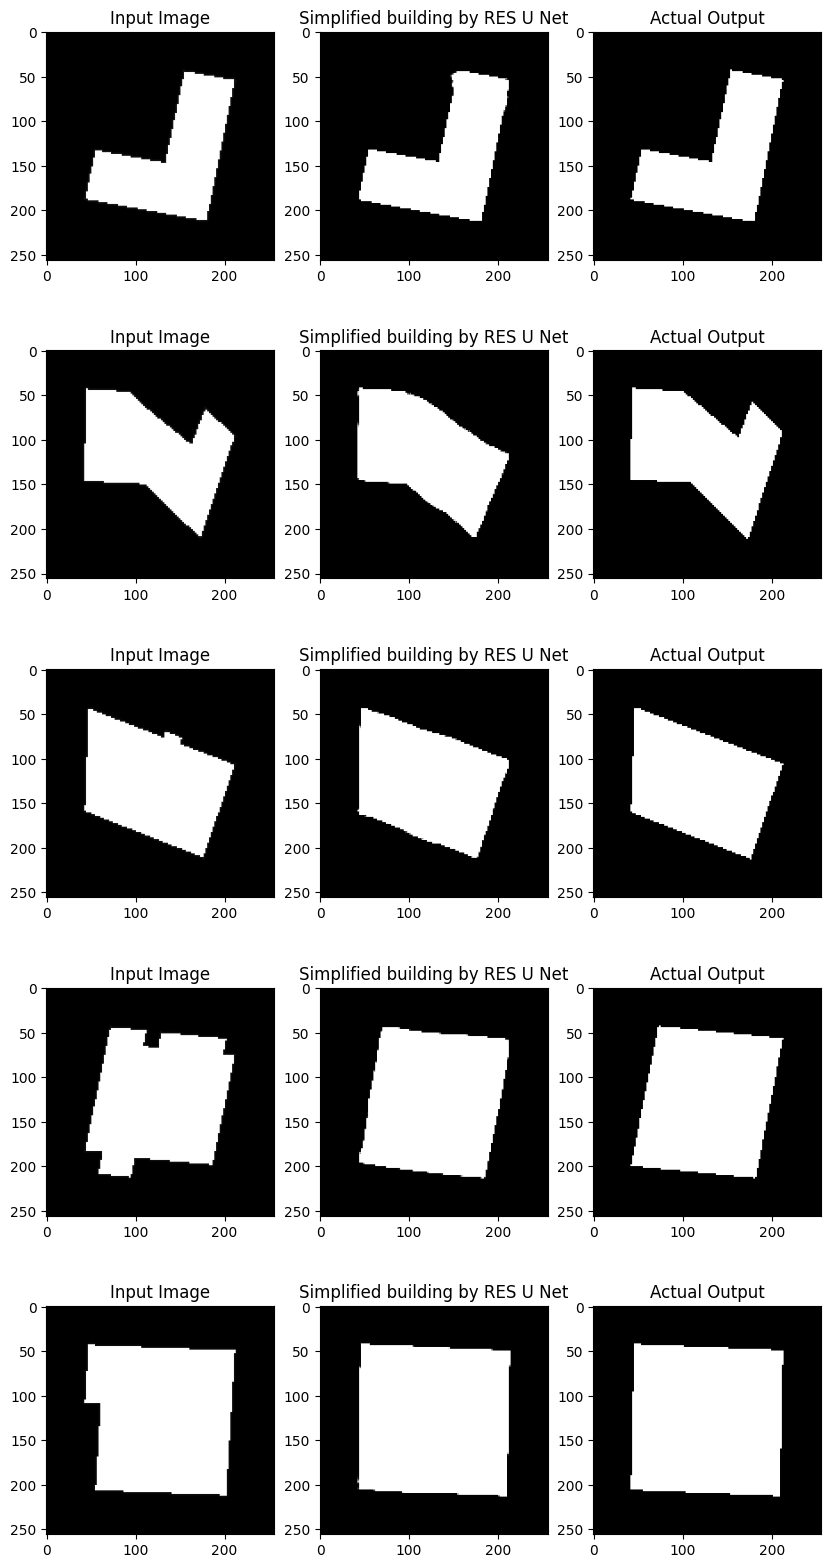

In [25]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for i in range(5):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Input Image')
        elif j == 1:
            axs[i, j].imshow(preds_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Simplified building by RES U Net')
       
        elif j == 2:
            axs[i, j].imshow(Y_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Actual Output')

# **Prediction on Testing Dataset**

In [27]:
preds = model.predict(X_testNorm)

16/16 [==============================] - 4s 246ms/step


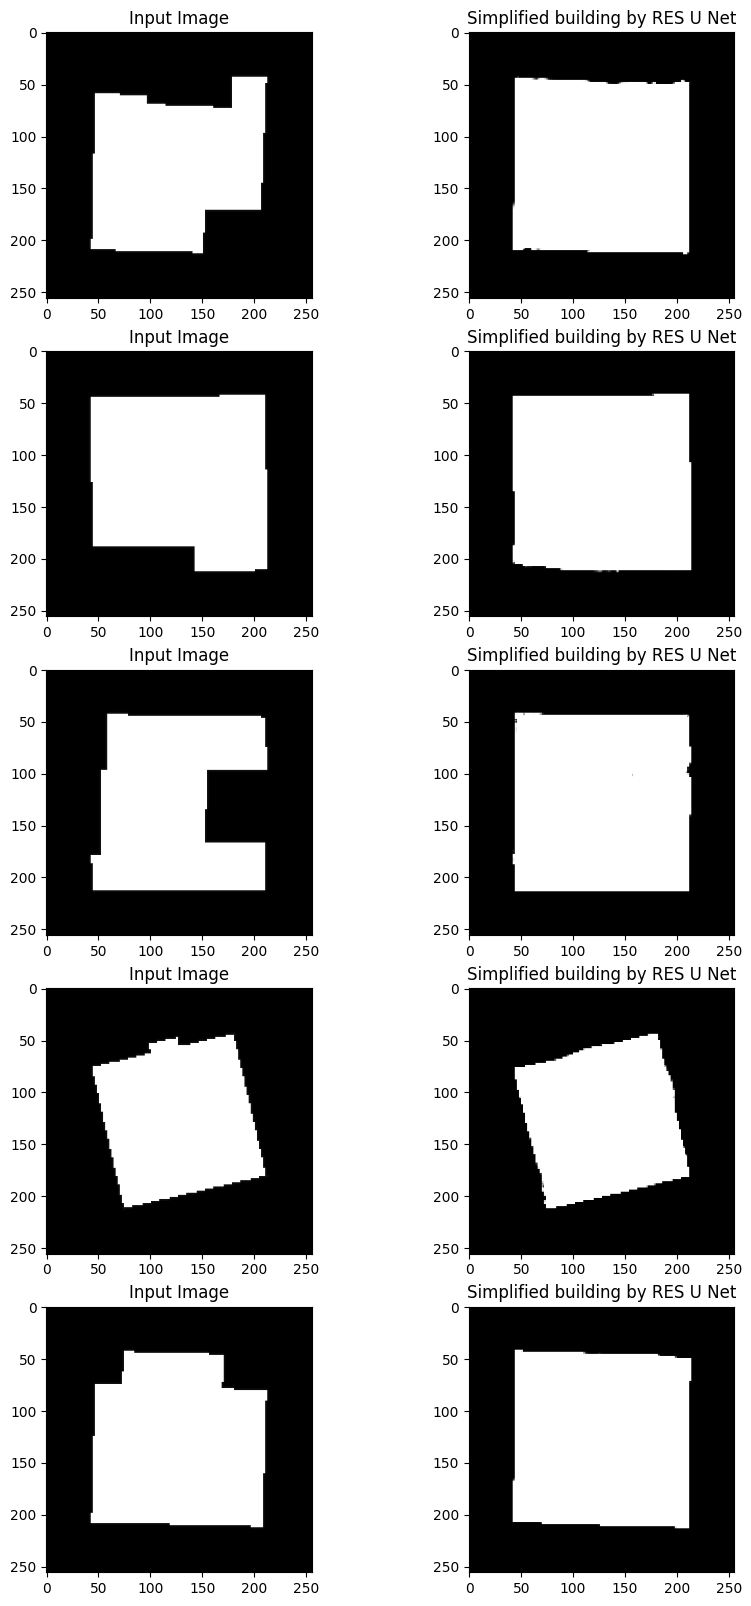

In [32]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Input Image')
        else:
            axs[i, j].imshow(preds[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Simplified building by RES U Net')

# **Save the Model**


In [29]:
!mkdir -p resunet_4k_dataset_model

In [30]:
model.save('resunet_4k_dataset_model/resunet')

INFO:tensorflow:Assets written to: resunet_4k_dataset_model/resunet/assets


INFO:tensorflow:Assets written to: resunet_4k_dataset_model/resunet/assets


In [31]:
model.save_weights('resunet_4k_dataset_model/my_model_weights.h5')